# Create Dataset for Jet Tagging @ L1 studies

In [1]:
%%time
import pickle, uproot
import pandas as pd
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
mpl.rcParams.update({'font.size': 20})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

import numpy as np
import h5py
import os


CPU times: user 3.54 s, sys: 582 ms, total: 4.13 s
Wall time: 5.38 s


In [2]:
print(f"TensorFlow {tf.__version__}")
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')


TensorFlow 2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of available GPUs : 1


## Open the input ROOT files and check its contents

In [3]:
fname = "/Users/sznajder/WorkM1/workdir/Notebooks/CMS_L1TML/JetID_hackaton/jetTuple.root"

f = uproot.open(fname)

f["jetntuple/tree"].keys() 


['run',
 'lumi',
 'event',
 'jet_eta',
 'jet_phi',
 'jet_pt',
 'jet_pt_raw',
 'jet_mass',
 'jet_energy',
 'jet_px',
 'jet_py',
 'jet_pz',
 'jet_bjetscore',
 'jet_reject',
 'jet_tauflav',
 'jet_muflav',
 'jet_elflav',
 'jet_taudecaymode',
 'jet_lepflav',
 'jet_taucharge',
 'jet_genmatch_pt',
 'jet_genmatch_eta',
 'jet_genmatch_phi',
 'jet_genmatch_mass',
 'jet_genmatch_hflav',
 'jet_genmatch_pflav',
 'jet_npfcand',
 'jet_pfcand_pt',
 'jet_pfcand_px',
 'jet_pfcand_py',
 'jet_pfcand_pz',
 'jet_pfcand_pt_log',
 'jet_pfcand_eta',
 'jet_pfcand_phi',
 'jet_pfcand_mass',
 'jet_pfcand_energy',
 'jet_pfcand_energy_log',
 'jet_pfcand_puppiweight',
 'jet_pfcand_z0',
 'jet_pfcand_dxy',
 'jet_pfcand_dxy_custom',
 'jet_pfcand_id',
 'jet_pfcand_charge',
 'jet_pfcand_pperp_ratio',
 'jet_pfcand_ppara_ratio',
 'jet_pfcand_deta',
 'jet_pfcand_dphi',
 'jet_pfcand_etarel',
 'jet_pfcand_track_chi2',
 'jet_pfcand_track_chi2norm',
 'jet_pfcand_track_qual',
 'jet_pfcand_track_npar',
 'jet_pfcand_track_nstubs',


## Transform into Awkward arrays and filter its contents

In [4]:
#    filter_name = "/(L1Mu|L1EG|L1Jet|L1EtSum)_(pt|eta|phi|etSumType)/", 

filter = "/(jet)_(eta|phi|pt|pt_raw|mass|energy|px|py|pz|bjetscore|reject|tauflav|muflav|elflav|taudecaymode|lepflav|taucharge|genmatch_pt|genmatch_eta|genmatch_phi|genmatch_mass|genmatch_hflav|genmatch_pflav|npfcand|pfcand_pt|pfcand_px|pfcand_py|pfcand_pz|pfcand_pt_log|pfcand_eta|pfcand_phi|pfcand_mass|pfcand_energy|pfcand_energy_log|pfcand_puppiweight|pfcand_z0|pfcand_dxy|pfcand_dxy_custom|pfcand_id|pfcand_charge|pfcand_pperp_ratio|pfcand_ppara_ratio|pfcand_deta|pfcand_dphi|pfcand_etarel|pfcand_track_chi2|pfcand_track_chi2norm|pfcand_track_qual|pfcand_track_npar|pfcand_track_nstubs|pfcand_track_vx|pfcand_track_vy|pfcand_track_vz|pfcand_track_pterror|pfcand_cluster_hovere|pfcand_cluster_sigmarr|pfcand_cluster_abszbarycenter|pfcand_cluster_emet|pfcand_cluster_egvspion|pfcand_cluster_egvspu)/"
#filter = "/(jet)_(pt|eta|phi|pfcand|bjetscore)/"
#filter ="jet_*"

data1 = f["jetntuple/tree;6"].arrays(
#     entry_stop = 1e1, 
    filter_name = filter, 
    how = "zip")

data2 = f["jetntuple/tree;7"].arrays(
#     entry_stop = 1e1, 
    filter_name = filter, 
    how = "zip")

data = ak.concatenate([data1,data2])

print("Data Fields:",data.fields)
print("Data Fields:",data.fields)
print("JET PFcand Fields:",data.jet_pfcand.fields)


Data Fields: ['jet_eta', 'jet_phi', 'jet_pt', 'jet_pt_raw', 'jet_mass', 'jet_energy', 'jet_px', 'jet_py', 'jet_pz', 'jet_bjetscore', 'jet_reject', 'jet_tauflav', 'jet_muflav', 'jet_elflav', 'jet_taudecaymode', 'jet_lepflav', 'jet_taucharge', 'jet_genmatch_pt', 'jet_genmatch_eta', 'jet_genmatch_phi', 'jet_genmatch_mass', 'jet_genmatch_hflav', 'jet_genmatch_pflav', 'jet_npfcand', 'jet_pfcand']
Data Fields: ['jet_eta', 'jet_phi', 'jet_pt', 'jet_pt_raw', 'jet_mass', 'jet_energy', 'jet_px', 'jet_py', 'jet_pz', 'jet_bjetscore', 'jet_reject', 'jet_tauflav', 'jet_muflav', 'jet_elflav', 'jet_taudecaymode', 'jet_lepflav', 'jet_taucharge', 'jet_genmatch_pt', 'jet_genmatch_eta', 'jet_genmatch_phi', 'jet_genmatch_mass', 'jet_genmatch_hflav', 'jet_genmatch_pflav', 'jet_npfcand', 'jet_pfcand']
JET PFcand Fields: ['pt', 'px', 'py', 'pz', 'pt_log', 'eta', 'phi', 'mass', 'energy', 'energy_log', 'puppiweight', 'z0', 'dxy', 'dxy_custom', 'id', 'charge', 'pperp_ratio', 'ppara_ratio', 'deta', 'dphi', 'etare

## B-Jet definition

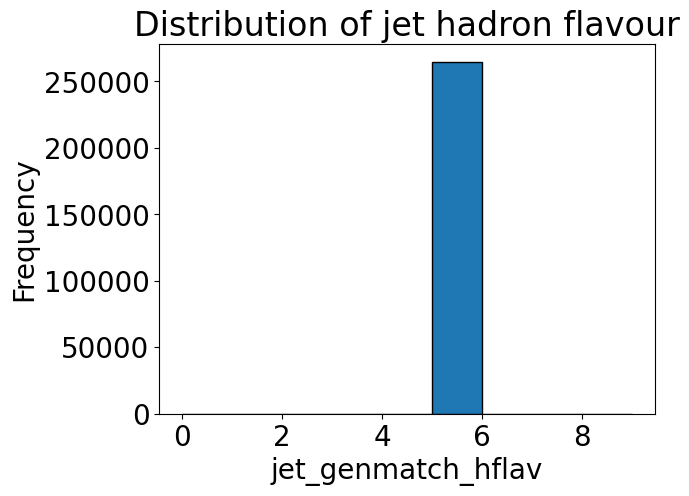

In [5]:
# Definition of signal (b jets)

condition_sig = (
    (data['jet_genmatch_pt'] > -1) &
    (data['jet_muflav'] == 0) &
    (data['jet_tauflav'] == 0) &
    (data['jet_elflav'] == 0) &
    (data['jet_genmatch_hflav'] == 5)
)

jet_ptmin =   (data['jet_pt'] > 15.) 

data_sig = data[(condition_sig & jet_ptmin)]

# Validation: check that signal only contains jets with hadron flavour 5
jethflav = ak.to_numpy(data_sig['jet_genmatch_hflav'])
flat_jethflav=jethflav.flatten()
type(flat_jethflav)
plt.hist(flat_jethflav, bins=np.arange(0, 10, 1), edgecolor='black')
plt.title('Distribution of jet hadron flavour')
plt.xlabel('jet_genmatch_hflav')
plt.ylabel('Frequency')
plt.show()

## Background definition

In [6]:
# Definition of background (non-b jets)
condition_bkg = ~condition_sig

data_bkg = data[condition_bkg & jet_ptmin]

# Sanity check
print("Length of data:    ", len(data))
print("Length of data_sig:", len(data_sig))
print("Length of data_bkg:", len(data_bkg))

Length of data:     2068405
Length of data_sig: 264876
Length of data_bkg: 1164365


## Sort Signal and Background samples for training

In [7]:
Njets = 100000

# Pick randomly 100k signal jets
random_indices_sig = np.random.choice(len(data_sig), size=Njets, replace=False)
data_sig = data_sig[random_indices_sig]
print("Length of data_sig now:", len(data_sig))

# Pick randomly 100k bkg jets
random_indices_bkg = np.random.choice(len(data_bkg), size=Njets, replace=False)
data_bkg = data_bkg[random_indices_bkg]
print("Length of data_bkg now:", len(data_bkg))

# Look at the final structure of data
data_sig.type.show()


Length of data_sig now: 100000
Length of data_bkg now: 100000
100000 * {
    jet_eta: float32,
    jet_phi: float32,
    jet_pt: float32,
    jet_pt_raw: float32,
    jet_mass: float32,
    jet_energy: float32,
    jet_px: float32,
    jet_py: float32,
    jet_pz: float32,
    jet_bjetscore: float32,
    jet_reject: bool,
    jet_tauflav: int32,
    jet_muflav: int32,
    jet_elflav: int32,
    jet_taudecaymode: int32,
    jet_lepflav: int32,
    jet_taucharge: int32,
    jet_genmatch_pt: float32,
    jet_genmatch_eta: float32,
    jet_genmatch_phi: float32,
    jet_genmatch_mass: float32,
    jet_genmatch_hflav: uint32,
    jet_genmatch_pflav: int32,
    jet_npfcand: uint32,
    jet_pfcand: var * {
        pt: float32,
        px: float32,
        py: float32,
        pz: float32,
        pt_log: float32,
        eta: float32,
        phi: float32,
        mass: float32,
        energy: float32,
        energy_log: float32,
        puppiweight: float32,
        z0: float32,
        dx

## Important: in DATA one has to only filter on bx=0 for proper usage!
### Below is an example of how this can be achieved:
### We shall filter the bx=0 L1 objects from the events -> need to add bx to the array reading step above.
### data_bkg_allBX = data_bkg
### bx = 0
### data_bkg_bx0 = {}
### for obj in data_bkg_allBX.fields:
###    # make a mask to filter out bx=0 only
###    bx_mask = data_bkg_allBX[obj].bx == bx
###    data_bkg_bx0[obj] = data_bkg_allBX[obj][bx_mask]
### data_bkg = ak.Array(data_bkg_bx0)

## Signal and background PFCAND multiplicity distributions

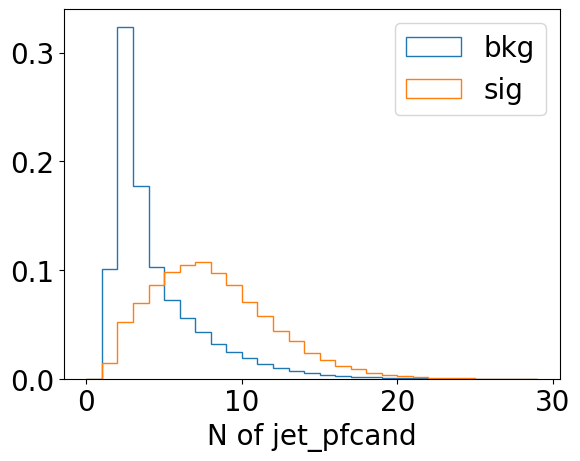

In [8]:
for obj in ['jet_pfcand']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj])
        plt.hist(num, label = label, bins = range(30), density = True, 
                 #log = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()
#     plt.grid()

## Signal and background PUPPI weight distributions

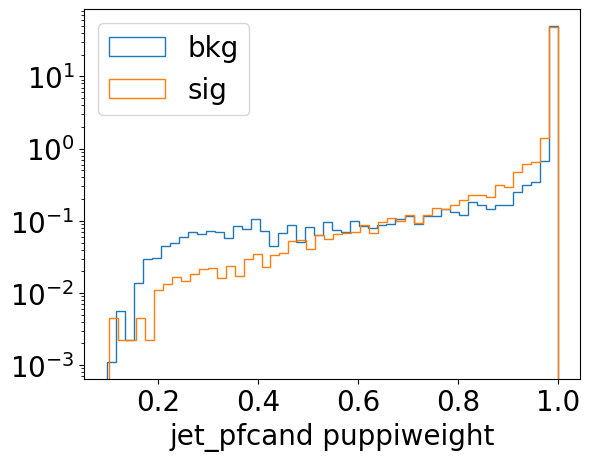

In [9]:
for obj in [ 'jet_pfcand']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # notice the [:,:1] below -> we slice the array and select no more than the first entry per event
        # ak.ravel makes the array flat such that we can fill a histogram
        plt.hist(ak.ravel(data[obj].puppiweight[:,:1]), label = label, bins = 50, density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} puppiweight")
    plt.legend()
#     plt.grid()


## Convert data to regular array for ML usage
#### Due to the variable number of objects per event (except for the sums) we need to convert the data from the jagged 
### format to a tabular (regular) format with the rows corresponding to events and the columns to the variables.
### For that we have to pick:
### An order of objects e.g. Sums, Jets, EG, Muons
### The variables for each
### The max number of objects we want to use ( nconstit )
### Constituents features ( nfeat )
### The values to use to pad empty objects
### We can write this down in the following dictionary:

In [10]:
# Define number of jet constituents and number of constituents features
nconstit = 16

# All PF candidate properties
pfcand_fields_all = ['pt','px','py','pz','pt_log','eta','phi','mass','energy','energy_log','puppiweight','z0','dxy','dxy_custom','id','charge','pperp_ratio','ppara_ratio','deta','dphi','etarel','track_chi2','track_chi2norm','track_qual','track_npar','track_nstubs','track_vx','track_vy','track_vz','track_pterror','cluster_hovere','cluster_sigmarr','cluster_abszbarycenter','cluster_emet','cluster_egvspion','cluster_egvspu']
# A slightly reduced set
pfcand_fields = ['pt','deta','dphi','dxy_custom','etarel','puppiweight']
nfeat = len(pfcand_fields)

objects = [
  {"name" : "pfcand", "key" : "jet_pfcand", "fields" : pfcand_fields, "n_obj" : nconstit},
]

## We will use dedicated functions to ease this conversion from jagged to regular format.
### These functions are taken from the end-to-end ML@L1 framework of the TOPO team: (authors: @flabe and @alobanov)
### https://gitlab.cern.ch/uhh-l1t/uhh_mlatl1_run3

In [11]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    # cuts are defined as a dictionary containing the relevant keys:
    # cuttype, field and value
    if cuts:
        for cut in cuts:
            if cut["cuttype"] == "equals": objects = objects[objects[cut["field"]] == cut["value"]]
            else: raise Exception("Cuttype {} is not implemented.".format(cut["cuttype"]))
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatDataTopotrigger(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above
    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    for obj in objects: 
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return np.concatenate(dataList, axis = 0).T, varList

## Create Datasets for training

In [12]:
x_sig, var_names = formatDataTopotrigger(data_sig, objects, verbosity = 99)
x_bkg, var_names = formatDataTopotrigger(data_bkg, objects, verbosity = 0)
x_sig.shape
x_bkg.shape

The input variables are the following:
['pfcand_0_pt', 'pfcand_0_deta', 'pfcand_0_dphi', 'pfcand_0_dxy_custom', 'pfcand_0_etarel', 'pfcand_0_puppiweight', 'pfcand_1_pt', 'pfcand_1_deta', 'pfcand_1_dphi', 'pfcand_1_dxy_custom', 'pfcand_1_etarel', 'pfcand_1_puppiweight', 'pfcand_2_pt', 'pfcand_2_deta', 'pfcand_2_dphi', 'pfcand_2_dxy_custom', 'pfcand_2_etarel', 'pfcand_2_puppiweight', 'pfcand_3_pt', 'pfcand_3_deta', 'pfcand_3_dphi', 'pfcand_3_dxy_custom', 'pfcand_3_etarel', 'pfcand_3_puppiweight', 'pfcand_4_pt', 'pfcand_4_deta', 'pfcand_4_dphi', 'pfcand_4_dxy_custom', 'pfcand_4_etarel', 'pfcand_4_puppiweight', 'pfcand_5_pt', 'pfcand_5_deta', 'pfcand_5_dphi', 'pfcand_5_dxy_custom', 'pfcand_5_etarel', 'pfcand_5_puppiweight', 'pfcand_6_pt', 'pfcand_6_deta', 'pfcand_6_dphi', 'pfcand_6_dxy_custom', 'pfcand_6_etarel', 'pfcand_6_puppiweight', 'pfcand_7_pt', 'pfcand_7_deta', 'pfcand_7_dphi', 'pfcand_7_dxy_custom', 'pfcand_7_etarel', 'pfcand_7_puppiweight', 'pfcand_8_pt', 'pfcand_8_deta', 'pfcand_

(100000, 96)

## Plot Input Data distributions

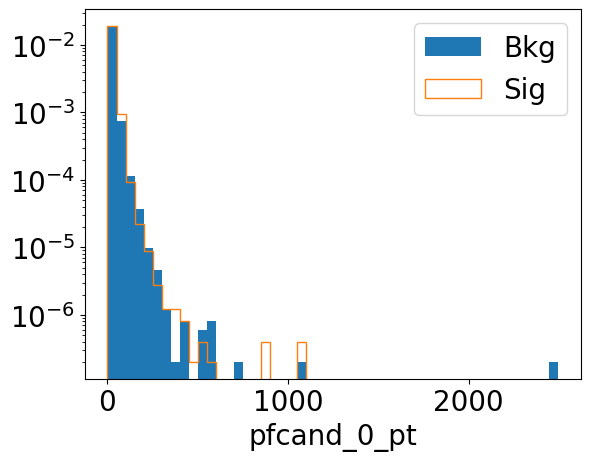

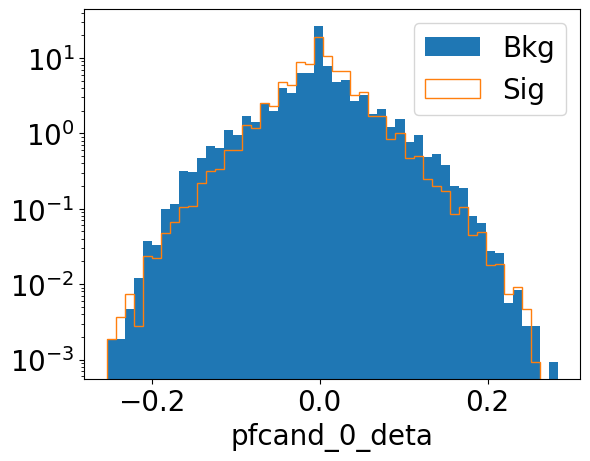

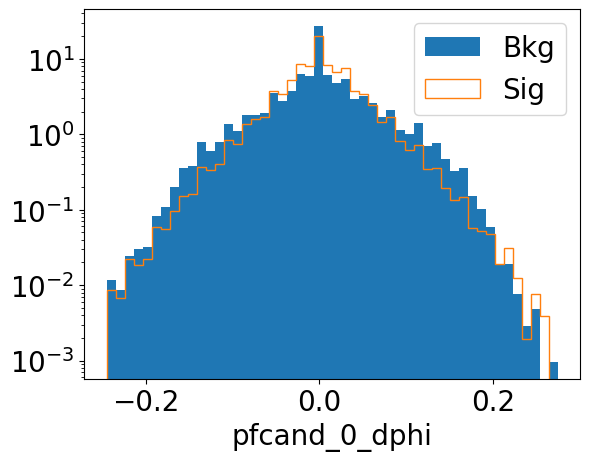

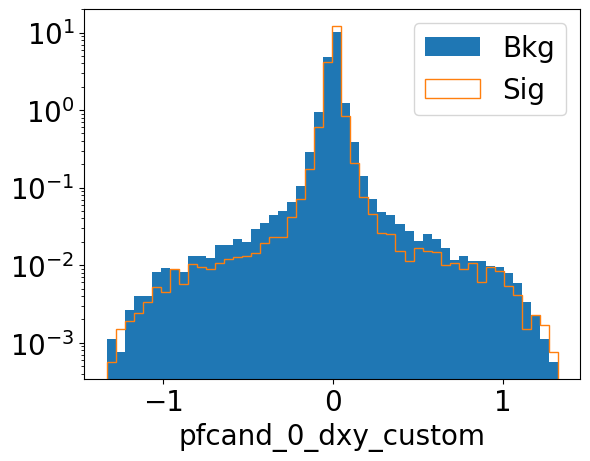

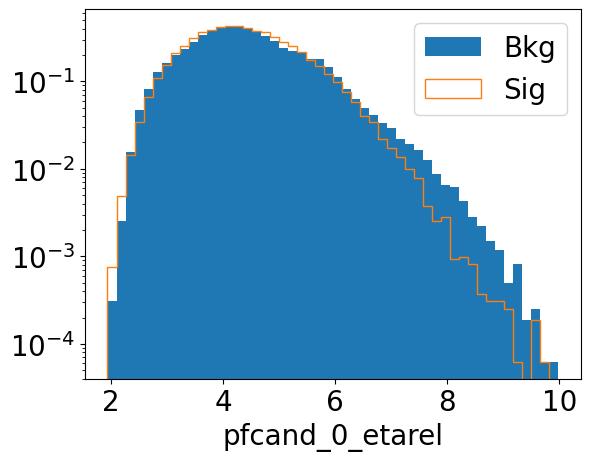

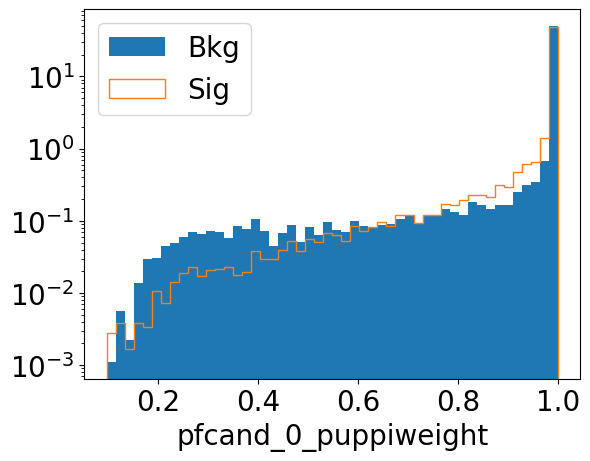

In [13]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()

## Create Labels for training

In [14]:
# creating labels
y_bkg = np.zeros(len(x_bkg))
y_sig = np.ones(len(x_sig))

# combining signal & bkg
x = np.concatenate((x_bkg, x_sig))
y = np.concatenate((y_bkg, y_sig))

## Normalize NN inputs 

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(x)
x_scaled = scaler.transform(x)

# make directory
outdir = "part1_outputs_btagging/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

with open(outdir+"scaler.pkl", 'wb') as file_pi: 
    pickle.dump(scaler, file_pi)

## Reshape Data and Split into Train and Test

In [16]:
from sklearn.model_selection import train_test_split

# Reshape inputs and targets 
x_scaled = np.reshape(x_scaled,[-1,nconstit,nfeat])
y = np.reshape(y,[-1,1])

# Shuffle jet constituents
# Shuffles jet constituents
print("Before --->> x_scaled[0,0:4,0] = ",x_scaled[0,0:4,0])
for i in range(x_scaled.shape[0]):
  x_scaled[i] = x_scaled[i, np.random.permutation(nconstit), :]
print("After --->> x_scaled[0,0:4,0] = ",x_scaled[0,0:4,0])


# Split data into train and test shuffling events
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, shuffle=True)


# Reshape signal and background samples
x_sig = scaler.transform(x_sig)
x_bkg = scaler.transform(x_bkg)

x_sig = np.reshape(x_sig,[-1,nconstit,nfeat])
x_bkg = np.reshape(x_bkg,[-1,nconstit,nfeat])


Before --->> x_scaled[0,0:4,0] =  [-0.61374509 -0.61275326 -0.53372582 -0.74808855]
After --->> x_scaled[0,0:4,0] =  [-0.68019188 -0.21163739 -0.61374509 -0.14465272]


## Save Data to Parket files

In [17]:
ak.to_parquet(X_train, outdir+"X_train_scaled.parquet")
ak.to_parquet(y_train, outdir+"y_train_scaled.parquet")
ak.to_parquet(X_test, outdir+"X_test_scaled.parquet")
ak.to_parquet(y_test, outdir+"y_test_scaled.parquet")
ak.to_parquet(x_sig, outdir+"x_sig_scaled.parquet")
ak.to_parquet(x_bkg, outdir+"x_bkg_scaled.parquet")
! ls -lthr part1_outputs_btagging

total 173328
-rw-r--r--  1 sznajder  staff   1.4K 14 Dec 17:24 y_sig_scaled.parquet
-rw-r--r--  1 sznajder  staff   1.4K 14 Dec 17:24 y_bkg_scaled.parquet
-rw-r--r--  1 sznajder  staff   2.7K 15 Dec 06:09 scaler.pkl
-rw-r--r--  1 sznajder  staff    34M 15 Dec 06:09 X_train_scaled.parquet
-rw-r--r--  1 sznajder  staff    69K 15 Dec 06:09 y_train_scaled.parquet
-rw-r--r--  1 sznajder  staff   8.5M 15 Dec 06:09 X_test_scaled.parquet
-rw-r--r--  1 sznajder  staff    18K 15 Dec 06:09 y_test_scaled.parquet
-rw-r--r--  1 sznajder  staff    25M 15 Dec 06:09 x_sig_scaled.parquet
-rw-r--r--  1 sznajder  staff    13M 15 Dec 06:09 x_bkg_scaled.parquet


## Save data in npy for HLS4ML

In [19]:
np.save( outdir+"X_test_btag_nconst_{}".format(nconstit), X_test)
np.save( outdir+"Y_test_btag_nconst_{}".format(nconstit), y_test)